# QHED on Simulated Noisy Hardware

In [1]:
from math import log
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '.')

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library import MCXGate
from qiskit.providers.fake_provider import FakeHanoi
import mapomatic as mm

Much of this will be a repeate of the previous notebook. I am leaving it in as a reminder for quick reference if there are any questions.

After importing all of the required modules, we need to extract information from our noisy backend simulator. In this case I am using FakeHanoi however you can feel free to choose others found [here](https://qiskit.org/documentation/apidoc/providers_fake_provider.html#:~:text=The%20fake%20backends%20are%20built,%2C%20error%20rate%2C%20etc.). As for our optimizations in this, we are using the transpiler as well as a simple reengineering of the decrement permutation. We have a measurement readout error mitigation called [mthree](https://qiskit.org/documentation/partners/mthree/) where more information can be found [here](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html). We cannot use mthree for these optimization metrics because it actually involves the measurement of the circuit outputs which we are not doing here.

Mapomatic produces a circuit layout which is generalized to have the best fault tolerance which is important for the amplitude encoding since for each image we are required to map many different circuits. But we are only required to map one single QHED circuit per domain. Example of the mapomatic protocol:

1. Transpile the circuit multiple times since it is a stochastic function
2. Find the Circuit with the least amount of cx gates
3. ..... mapomatic stuff to find the most fault tolerant mapping ....
4. Return the mapping
5. Apply that mapping to each circuit as a 'starting point' for the transpiler

But since we only have to map one QHED circuit for each domain we stop after step 2:

1. Transpile the circuit multiple times since it is a stochastic function
2. Return the Circuit with the least amount of cx gates

We do not need a general mapping to be input into the transpiler *again* in hopes of producing the circuit with the least amount of cx gates when we already have that circuit available to us. I am sure that there are other tools which are available to find the directed graph of "least error" but that is an entirely different project by itself.

In [2]:
# I am finding that much of the real hardware have lesser error values
# in general than the FakeHardware() backends.
'''
provider = IBMQ.load_account()
print(provider.backends())
qbackend = provider.get_backend('ibmq_manila')
'''

qbackend = FakeHanoi()

properties = qbackend.properties()
config = qbackend.configuration()
defaults = qbackend.defaults()

basis_gates = config.basis_gates

print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}.\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

#***** Display Gate Errors *****
# Compute average SX gate error for backend
avg_sx_err = np.mean([properties.gate_error("sx", i) for i in range(config.n_qubits)])

# Compute average X gate error for backend
avg_x_err = np.mean([properties.gate_error("x", i) for i in range(config.n_qubits)])

# Compute average RZ gate error for backend
avg_rz_err = np.mean([properties.gate_error("rz", i) for i in range(config.n_qubits)])

avg_single_qb_err = (avg_sx_err + avg_x_err + avg_rz_err)/3


# Compute the average CNOT gate error for backend
avg_cx_err = np.mean(
    [properties.gate_error("cx", (cm[0], cm[1])) for cm in config.coupling_map]
)


# Display gate error averages
print(f"Average CX gate error: {avg_cx_err:.5f}")
print(f"Average single qubit SX gate error: {avg_sx_err:.5f}")
print(f"Average single qubit RZ gate error: {avg_rz_err:.5f}")
print(f"Average single qubit X gate error: {avg_x_err:.5f}")

This backend is called fake_hanoi, and is on version 1.0.18. It has 27 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].

Average CX gate error: 0.00934
Average single qubit SX gate error: 0.00022
Average single qubit RZ gate error: 0.00000
Average single qubit X gate error: 0.00022


What we have done is extract the basis gates and their respective error rate for the hardware. These are the gates which are executed on the real device. Whichever unitaries are used in your circuit design, they are decomposed into series of these gates. We average the error accross the hardware for each gate for future computational time. There, is of course, an explicity way of finding a more exact error per circuit. However, on real hardware the error rates are variable! I believe that some of the error rates are updated daily. So the average error rates of the fake backend suit our needs.

The circuit proposed by the publishers involves the use of a *n+1* Decrement Permutation where *n* is the number of encoding qubits. The Decrement Unitary has the following matrix representation:

$D_{2^{n+1}} =
    \begin{bmatrix}
    0 & 1 & 0 & 0 & \dots & 0 & 0\\
    0 & 0 & 1 & 0 & \dots & 0 & 0\\
    0 & 0 & 0 & 1 & \dots & 0 & 0\\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
    0 & 0 & 0 & 0 & \dots & 0 & 1\\
    1 & 0 & 0 & 0 & \dots & 0 & 0
    \end{bmatrix}$
    
With the authors' proposal for their QHED circuit taking the form:



![qhed_circ](./img/qhed_circuit.png)

Without getting into great detail about the edge detection properties circuit here, we will demonstrate how fidelity issues of the circuit may be mitigated by the use of a reconstruction of the Decrement Permutation. We find that in order to achieve the Decrement operation applied *n+1* qubits using the *n+1* qubits (without any ancillaries) the circuit representation of the unitary takes the following form with either open or closed controls respectively:

![decrement](./img/decrement.png)
![decrement](./img/decrement_closed.png)

The open controls indicate that there is an activation when all the controls for a qubit are in the $|0\rangle$ state. This becomes an issue due to the backend topology of quantum hardware. Shown below is the qubit mapping for the *qim_nairobe* hardware:

![Nairobe](./img/ibm_nairobi_calibrations_readout_error_cx_map_2023-01-19T20_31_29Z.png)

In this case the qubit mappings may allow either *q_1* or *q_5* to experience entanglement with up to 3 other qubits each. What if we have a larger decrement permutation? How could it be that we have a single qubit entangled with 4 or more control qubits? The answer to that requires a mapping of an exponential number of cx gates which propogate information across the qubits. For example, the toffoli gate (two control qubits with one target) requires no fewer than 5 cx gates. Per each control we add, our number of CX gates can potentially double, if not more. Furthermore, we are adding MCX gates linearly per addition to *n* encoding qubits.

In [3]:
n = 3
qc = QuantumCircuit(n)
qc.ccx(0, 1, n-1)
qc_t = transpile(qc, backend=qbackend, basis_gates=basis_gates, optimization_level=3)

print("Toffoli Gate", qc)
print("Number of CX Gates:", qc_t.count_ops()['cx'])


n = 4
qc = QuantumCircuit(n)
qc.append(MCXGate(n-1),list(range(0,n)))
qc_t = transpile(qc, backend=qbackend, basis_gates=basis_gates, optimization_level=3)

print("\n\nMCX gate with 3 controls",qc)
print("Number of CX Gates:", qc_t.count_ops()['cx'])

n = 5
qc = QuantumCircuit(n)
qc.append(MCXGate(n-1),list(range(0,n)))
qc_t = transpile(qc, backend=qbackend, basis_gates=basis_gates, optimization_level=3)

print("\n\nMCX gate with 4 controls",qc)
print("Number of CX Gates:", qc_t.count_ops()['cx'])

Toffoli Gate           
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
Number of CX Gates: 7


MCX gate with 3 controls           
q_0: ──■──
       │  
q_1: ──■──
       │  
q_2: ──■──
     ┌─┴─┐
q_3: ┤ X ├
     └───┘
Number of CX Gates: 36


MCX gate with 4 controls           
q_0: ──■──
       │  
q_1: ──■──
       │  
q_2: ──■──
       │  
q_3: ──■──
     ┌─┴─┐
q_4: ┤ X ├
     └───┘
Number of CX Gates: 79


What we could do is use some ancillary qubits in order to create our decrement permutation using only cx and toffoli gates. This comes by a simple change to the increment gates found [here](https://algassert.com/circuits/2015/06/12/Constructing-Large-Increment-Gates.html). We make an alteration to the engineering of the gates such that the controls on the decrement qubits are switched for open controls. Shown below is the *n = 3* case for the decrement gate.

![decrement_op](./img/decrement_op.png)

The *g* qubits are all reset to 0, an important qualification to allow the *q* qubits to perform the decrement permutation. This change gives us the new *2n* QHED circuit.

![qhed_circuit_op](./img/qhed_op.png)

Let us perform a full analysis of each decrement permutation. First, we begin with the *n+1* decrement permutation.

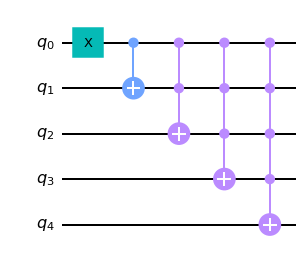

In [4]:
n_qubits = 4
qr = QuantumRegister(n_qubits+1, name="q")
qc = QuantumCircuit(qr)

qc.x(0)
qc.cx(0,1)
qc.append(MCXGate(2),[0,1,2])
for i in range(3, n_qubits+1):
    qc.append(MCXGate(i),list(range(0,i+1)))
qc.draw(output='mpl')

With the fully constructed circuit, we can demonstrate the resultant unitary:

In [5]:
from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

op = qi.Operator(qc)
array_to_latex(op.data, prefix="\\text{Decrement = }\n")

<IPython.core.display.Latex object>

We see how this circuit does in fact form the unitary required for the decrement permutation. Recall that the idea behind the decrement gate will take some $2^{n+1}$ vector and perform the following permutation:

$|\psi\rangle = \begin{bmatrix}c_{0}\\c_{1}\\ \vdots \\ c_{2^{n+1}-1}\end{bmatrix}$

$D_{2^{n+1}}|\psi\rangle = \begin{bmatrix}c_{1}\\ \vdots \\ c_{2^{n+1}-1} \\ c_{0}\end{bmatrix}$

We need to ensure that our new permutation does just that for the *n+1* encoding qubits with the ancillary qubits being unaffected. It is more difficult for this case because while we may simply output a unitary, we also expect there to be some differences because of the ancillary qubits. Let us take a look.

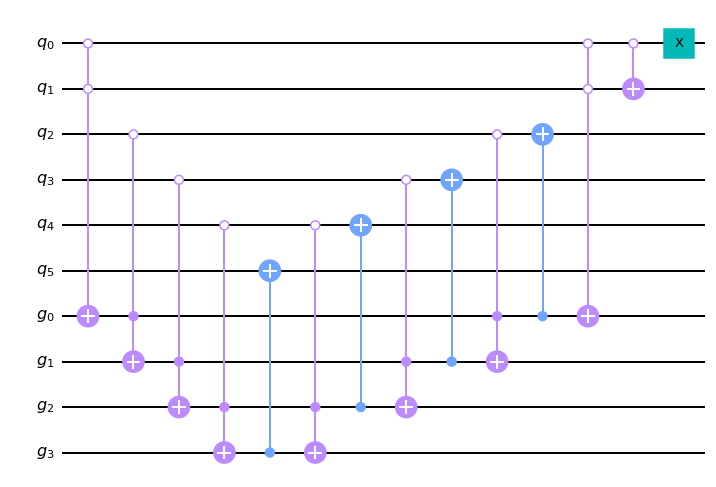

In [6]:
n_qubits = 5

g_qubits = n_qubits - 1
n = n_qubits + 1

qr = QuantumRegister(n, name="q")
gr = QuantumRegister(g_qubits, name="g")

qc = QuantumCircuit(qr, gr)

'''
Add X gates here to produce various states. Example:
Create the initial the state |101>.
The decrement permutation should produce the state |100>.
qc.x(0)
qc.x(2)
qc.barrier()
'''


#First Toffoli
qc.ccx(0, 1, n, ctrl_state='00')

#Descending
for i in range(2, n-1):
    qc.ccx(i, i + g_qubits, i + n - 1, ctrl_state='10')

#Sweep up
qc.cx(2*n-3,n-1)

for i in range(2*n-3,n,-1):
    qc.ccx(i-1, i-n+1,i, ctrl_state='01')

    qc.cx(i-1,i-n+1)

qc.ccx(0,1,n, ctrl_state='00')

qc.cx(0,1, ctrl_state='0')

qc.x(0)

qc.draw(output='mpl')

Let us look at the resultant unitary for this circuit:

In [22]:
op = qi.Operator(qc)
array_to_latex(op.data, prefix="\\text{Decrement = }\n", max_size=16)

<IPython.core.display.Latex object>

It can be seen that the upper left quadrant, the 8x8 block in the *n = 2* case, resembles our decrement permutation while the lower right quadrant is doing something funny! It can be reasoned that the first 3 qubits in some sense comprise the first 8 elements of the vector space. We cannot break the circuit into distinct unitaries such as a *q* unitary and *g* unitary because the sections are *dependant* on each other. There are controls and targets moving across sections which are not seperable. What we can do is perform a partial trace (outer product) of each sub system and see the results that each has on the input vector.

Now I claim that the qubits $q_{0}, q_{1}$ and $q_{2}$ will have enacted upon them the decrement permutation while the *g* qubit will return a value of 0. With an input vector of $|q_{0}q_{1}q_{2}\rangle = |000\rangle$ we would expect the decrement output to be in the pure state $D|000\rangle = |111\rangle$. At the same time, we wish our ancillary qubits to begin in the state $|g\rangle = |0\rangle$ and also have the same output. For more on the density matrix and mixed/pure states go [here](https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html).

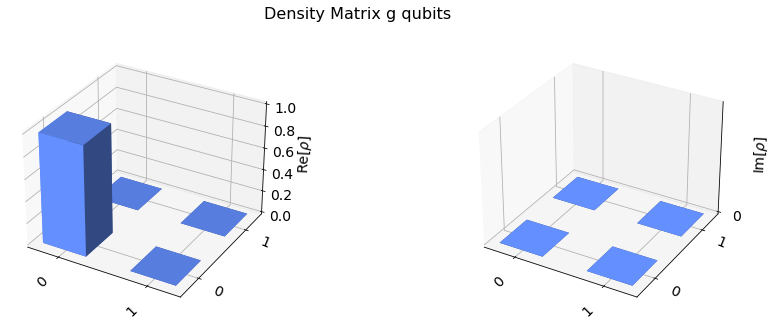

In [23]:
DM = DensityMatrix.from_instruction(qc)
PT = partial_trace(DM, list(range(0,n)))

from qiskit.visualization import plot_state_city
plot_state_city(PT, title='Density Matrix g qubits')

We see that the partial trace of the *g* qubits reveals a pure (real) $|0\rangle$ state which is exactly what we wanted! Now let us look at the *q* output portion of the circuit:

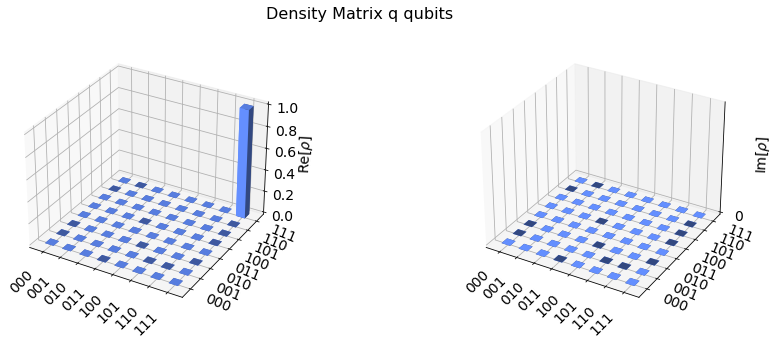

In [24]:
DM = DensityMatrix.from_instruction(qc)
PT = partial_trace(DM, list(range(n,n+g_qubits)))

plot_state_city(PT, title='Density Matrix q qubits')

Again, we receive the pure, real $|111\rangle$ state we desire. We can safeley say that the proposed decrement permutation does indeed perform correctly for the QHED circuit. If you remain unconvinced, edit the code to apply *NOT* gates in any combination to the input *q* states.

Next, we will import some methods to be used. First is the gate fidelity calculation called compute_circuit_gate_fidelity. It is a relatively simple heuristic which is presented by IBM:


$f_{circuit} = \bar{f}^{N_{1Q}}_{1Q}\bar{f}^{N_{2Q}}_{2Q}$


where $\bar{f}_{1Q}$ and $\bar{f}_{2Q}$ are the average single and two gate error rates for the hardware with $N_{1Q}$ and $N_{2Q}$ being the number of single and two qubit gates in the circuit.


The second method is transpile_min_cx. This is used to determine a mapping of the circuit design to hardware topology. The purpose of this is to minimize the number of cx operations in the circuit. The qiskit transpiler is stochastic so each time a circuit is transpiled we receive different results. A simple yet effective method is to transpile a circuit multiple times and choose the one with the lowest cx count. It is also possible to use a directed graph function to determine the ideal mapping, however that is not our area of research!

The last two methods are to create the QHED circuits. The first, *build_circ* creates the circuit proposed by [Yao et. al](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.031041) and the second, *build_circ_op*, creates the QHED circuit with my proposed alteration to the Decrement Permutation. 

In [10]:
def compute_circuit_gate_fidelity(
    num_two_q_gates, num_single_q_gates, ave_two_q_gate_fid, ave_single_q_fid
):
    """
    Estimate the fidelity of the combined two-qubit and single-qubit gates in a circuit.

    Args:
        num_two_q_gates - int; the number of two-qubit gates. Assumes the same two-qubit gate is used throughout the circuit.
        num_single_q_gates - int; the number of single-qubit gates. Assumes the same single-qubit gate is used throughout the circuit
        ave_two_q_gate_fid - float; the average fidelity of the two-qubit gate
        ave_single_q_fit - float; the average fidelity of the single-qubit gate

    Returns:
        fidelity - float; estimated fidelity of circuit operations (see paper for details)
    """

    return (ave_two_q_gate_fid**num_two_q_gates) * (
        ave_single_q_fid**num_single_q_gates
    )




def transpile_min_cx(qc):
    '''
    Find a circuit layout for some n number of qubits with a minimal cx count.
    Because qiskit is stochastic, we transpile some n qubit circuit 30 times and choose the mapping
    with the lowest cx count for that backend.
    
    Args:
        qc - some n qubit quantum circuit (in this case we use an amplitude encoded sub domain)
        
    Returns:
        trans_qc_list[best_idx] - transpiled circuit with a minimized cx count
    '''
    #Ancillary circuit, Mapped
    trans_qc_list = transpile([qc]*30, backend=qbackend, basis_gates=basis_gates, optimization_level=3)
    best_cx_count = [circ.count_ops()['cx'] for circ in trans_qc_list]
    best_idx = np.argmin(best_cx_count)
    return trans_qc_list[best_idx]






def build_circ(n_qubits):
    '''
    Builds the Image encoding circuit.

    Args:
        n_qubits - number of encoding qubits to be used.

    Returns:
        qc - n+1 qubit QHED circuit
    '''

    qr = QuantumRegister(n_qubits+1, name="q")
    qc = QuantumCircuit(qr)
    
    qc.h(0)
    qc.barrier()

    qc.x(0)
    qc.cx(0,1)
    qc.append(MCXGate(2),[0,1,2])

    for i in range(3, n_qubits+1):
        qc.append(MCXGate(i),list(range(0,i+1)))

    qc.barrier()
    qc.h(0)
        
    return qc



def build_circ_op(n_qubits):
    '''
    Builds the Image encoding circuit.

    Args:
        n_qubits - number of encoding qubits to be used.

    Returns:
        qc - n+1 qubit QHED circuit
    '''
    g_qubits = n_qubits - 1
    n = n_qubits + 1

    qr = QuantumRegister(n, name="q")
    gr = QuantumRegister(g_qubits, name="g")
    
    qc = QuantumCircuit(qr, gr)
    
    qc.h(0)
    
    #First Toffoli
    qc.ccx(0, 1, n, ctrl_state='00')

    #Descending
    for i in range(2, n-1):
        qc.ccx(i, i + g_qubits, i + n - 1, ctrl_state='10')

    #Sweep up
    qc.cx(2*n-3,n-1)

    for i in range(2*n-3,n,-1):
        qc.ccx(i-1, i-n+1,i, ctrl_state='01')

        qc.cx(i-1,i-n+1)

    qc.ccx(0,1,n, ctrl_state='00')

    qc.cx(0,1, ctrl_state='0')

    qc.x(0)

    qc.h(0)
    

    return qc

We're ready to get into it now. 

I am also defining some lists to store the calculated values for the fidelity, cx count, and depth. We are going to view both the Yao circuit and our circuits each optimized and unoptimized so we need four lists for each metric. We also create a dictionary for error exception handling. In python 3.9, we can merge dictionaries using:  

new_dictionary = baseline_dict | produced_dict

So if we return circuits which do not have certain basis gates we can overwrite them with a value of 0. Say, our circuit produced has no rz or cx gates but contains x and sx. Qiskit will produce the dictionary {'sx': 13, 'x': 5} and without the cx or rz contributions we will receive a key error and our fidelity calculation will crash:

new_dict = {'id': 0, 'rz': 0, 'sx': 0, 'x': 0, 'cx': 0, 'reset': 0} | {'sx': 13, 'x': 5}

new_dict = {'id': 0, 'rz': 0, 'sx': 13, 'x': 5, 'cx': 0, 'reset': 0}

Qiskit does not do these things for us so to avoid error we must implement it ourselves.

In [11]:

qc_cx_0 = []
qc_cx_op_0 = []

qc_cx_3 = []
qc_cx_op_3 = []

qc_fid_0 = []
qc_fid_op_0 = []

qc_fid_3 = []
qc_fid_op_3 = []

qc_depth_0 = []
qc_depth_op_0 = []

qc_depth_3 = []
qc_depth_op_3 = []

# This dictionary is created to avoid unescessary error exception handling
basis_dict = {gate:0 for gate in basis_gates}

We work now in loops of qubit domain decompositions. First, the image domain is split based on the number of qubits we have. We receive image vectors of size $2^{n}$. We then calculate the most optimal quantum register topology using mapomatic. From there, we transpile our circuits. One set is fully optimized, the other set is not. We can then calculate the metrics for each set of circuits and take the average. See the comments in the code for more details.

In [12]:
'''
Feel free to adjust this range to your liking

Warning: Anything past 5 or 6 qubits creates a major computational bottleneck
This is why we need to distribute not only the execution of circuits but also
the transpilation
'''

qubits = list(range(2,11))
for n_qubits in qubits:
    print("***** Working on", n_qubits, "of", qubits[-1],"qubits Decomp *****")

    '''
    This builds each circuit.
    '''
    qc = build_circ(n_qubits)
    qc_op = build_circ_op(n_qubits)


    '''
    Now we transpile the circuits. One set of circuits is transpiled with the minimized cx
    mapping as well as a level 3 optimization level.
    The other set of circuits has an optimization level of 0 without the register mapping. The idea
    is to see how much the optimizations make a difference with expanding domain sizes.
    '''
            
    qc_trans_3 = transpile_min_cx(qc)
    
    qc_trans_0 = transpile(qc, 
                    basis_gates=basis_gates, 
                    backend=qbackend,
                    optimization_level=0)

    qc_op_trans_3 = transpile_min_cx(qc_op)
    
    qc_op_trans_0 = transpile(qc_op, 
                    basis_gates=basis_gates, 
                    backend=qbackend,
                    optimization_level=0)


    '''
    Now we begin taking metrics. To find the depth of the circuit, I have experimented to find that
    6 layers of decomposition for the statevector method is appropriate to receive the lowest level
    of basis gates. 
    '''
    
    # Count ops and merge dictionaries
    qc_ops_0 = qc_trans_0.count_ops()
    qc_ops_0 = basis_dict | qc_ops_0
                         
    qc_ops_3 = qc_trans_3.count_ops()
    qc_ops_3 = basis_dict | qc_ops_3
                         
    qc_op_ops_0 = qc_op_trans_0.count_ops()
    qc_op_ops_0 = basis_dict | qc_op_ops_0
                         
    qc_op_ops_3 = qc_op_trans_3.count_ops()
    qc_op_ops_3 = basis_dict | qc_op_ops_3
    
    '''
    ***** Metrics for optimized Circuits *****
    '''
    
    # Depth
    qc_depth_0.append(qc_trans_0.decompose(reps=6).depth())
    qc_depth_3.append(qc_trans_3.decompose(reps=6).depth())
                      
    qc_depth_op_0.append(qc_op_trans_0.decompose(reps=6).depth())
    qc_depth_op_3.append(qc_op_trans_3.decompose(reps=6).depth())


    # Fidelity
    qc_fid_0.append(compute_circuit_gate_fidelity(qc_ops_0["cx"], qc_ops_0["sx"], 1 - avg_cx_err, 1 - avg_single_qb_err))
    qc_fid_3.append(compute_circuit_gate_fidelity(qc_ops_3["cx"], qc_ops_3["sx"], 1 - avg_cx_err, 1 - avg_single_qb_err))
    
    qc_fid_op_0.append(compute_circuit_gate_fidelity(qc_op_ops_0["cx"], qc_op_ops_0["sx"], 1 - avg_cx_err, 1 - avg_single_qb_err))
    qc_fid_op_3.append(compute_circuit_gate_fidelity(qc_op_ops_3["cx"], qc_op_ops_3["sx"], 1 - avg_cx_err, 1 - avg_single_qb_err))
    
    # CX Count
    qc_cx_0.append(qc_ops_0["cx"])
    qc_cx_op_0.append(qc_op_ops_0["cx"])
                         
    qc_cx_3.append(qc_ops_3["cx"])
    qc_cx_op_3.append(qc_op_ops_3["cx"])

    
    print("qc_depth_0 =", qc_depth_0[-1])
    print("qc_depth_3 =", qc_depth_3[-1])    
    print("qc_depth_op_0 =", qc_depth_op_0[-1])
    print("qc_depth_op_3 =", qc_depth_op_3[-1])
    print('\n\n')
                         
    print("qc_fid_0 =", qc_fid_0[-1])
    print("qc_fid_3 =", qc_fid_3[-1])    
    print("qc_fid_op_0 =", qc_fid_op_0[-1])
    print("qc_fid_op_3 =", qc_fid_op_3[-1])
    print('\n\n')
                        
    print("qc_cx_0 =", qc_cx_0[-1])
    print("qc_cx_3 =", qc_cx_3[-1])    
    print("qc_cx_op_0 =", qc_cx_op_0[-1])
    print("qc_cx_op_3 =", qc_cx_op_3[-1])
    print('\n\n')    

***** Working on 2 of 10 qubits Decomp *****
qc_depth_0 = 38
qc_depth_3 = 44
qc_depth_op_0 = 60
qc_depth_op_3 = 68



qc_fid_0 = 0.8362314996986244
qc_fid_3 = 0.900765790134638
qc_fid_op_0 = 0.7194541329771842
qc_fid_op_3 = 0.8036855706010533



qc_cx_0 = 19
qc_cx_3 = 11
qc_cx_op_0 = 35
qc_cx_op_3 = 23



***** Working on 3 of 10 qubits Decomp *****
qc_depth_0 = 83
qc_depth_3 = 112
qc_depth_op_0 = 108
qc_depth_op_3 = 112



qc_fid_0 = 0.6191632182107696
qc_fid_3 = 0.7884029733573165
qc_fid_op_0 = 0.4940345342997631
qc_fid_op_3 = 0.6912534500792598



qc_cx_0 = 51
qc_cx_3 = 25
qc_cx_op_0 = 75
qc_cx_op_3 = 39



***** Working on 4 of 10 qubits Decomp *****
qc_depth_0 = 262
qc_depth_3 = 223
qc_depth_op_0 = 161
qc_depth_op_3 = 186



qc_fid_0 = 0.265115904341469
qc_fid_3 = 0.41955695316862696
qc_fid_op_0 = 0.31177238890436737
qc_fid_op_3 = 0.5873836082529116



qc_cx_0 = 141
qc_cx_3 = 92
qc_cx_op_0 = 124
qc_cx_op_3 = 56



***** Working on 5 of 10 qubits Decomp *****
qc_depth_0 = 565
qc_de

In [13]:
# You can use this to copy and paste the raw data wherever you wish

print("qc_depth_0 =", qc_depth_0)
print("qc_depth_3 =", qc_depth_3)    
print("qc_depth_op_0 =", qc_depth_op_0)
print("qc_depth_op_3 =", qc_depth_op_3)
print('\n\n')

print("qc_fid_0 =", qc_fid_0)
print("qc_fid_3 =", qc_fid_3)    
print("qc_fid_op_0 =", qc_fid_op_0)
print("qc_fid_op_3 =", qc_fid_op_3)
print('\n\n')

print("qc_cx_0 =", qc_cx_0)
print("qc_cx_3 =", qc_cx_3)    
print("qc_cx_op_0 =", qc_cx_op_0)
print("qc_cx_op_3 =", qc_cx_op_3)
print('\n\n')


qc_depth_0 = [38, 83, 262, 565, 1083, 2189, 4344, 9148, 18675]
qc_depth_3 = [44, 112, 223, 540, 936, 1792, 4574, 9467, 19090]
qc_depth_op_0 = [60, 108, 161, 217, 294, 335, 382, 457, 564]
qc_depth_op_3 = [68, 112, 186, 261, 327, 362, 461, 514, 542]



qc_fid_0 = [0.8362314996986244, 0.6191632182107696, 0.265115904341469, 0.021847120335883898, 0.0002581392089892114, 3.6732350239568387e-08, 7.797188104673412e-16, 3.8318598025803602e-34, 5.371995530386116e-71]
qc_fid_3 = [0.900765790134638, 0.7884029733573165, 0.41955695316862696, 0.08377267577785298, 0.004474438323960483, 1.4352060420767062e-05, 1.0091112628615841e-10, 3.2102505981445774e-21, 1.8100804253251688e-41]
qc_fid_op_0 = [0.7194541329771842, 0.4940345342997631, 0.31177238890436737, 0.1709207944928515, 0.06318405617427326, 0.047210168788114786, 0.032418263628473935, 0.014188943440065918, 0.0035368611007145045]
qc_fid_op_3 = [0.8036855706010533, 0.6912534500792598, 0.5873836082529116, 0.4765907297772955, 0.4017745926548066, 0.32341

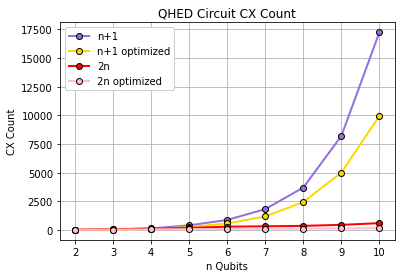

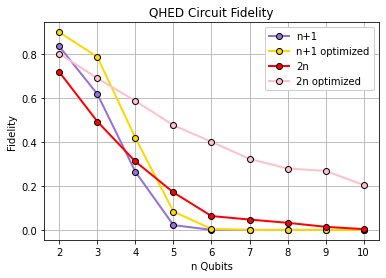

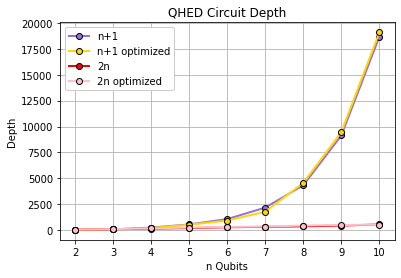

In [14]:

fig, ax = plt.subplots()
plt.plot(
    qubits,
    qc_cx_0,
    "-o",
    label="n+1",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_cx_3,
    "-o",
    label="n+1 optimized",
    linewidth=2,
    color="gold",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_cx_op_0,
    "-o",
    label="2n",
    linewidth=2,
    color="red",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_cx_op_3,
    "-o",
    label="2n optimized",
    linewidth=2,
    color="pink",
    markeredgecolor="k"
)
plt.ylabel("CX Count")
plt.xlabel("n Qubits")
plt.xticks(qubits)
plt.legend(framealpha=1)
plt.grid()
plt.title("QHED Circuit CX Count")
#plt.savefig("enc_cx.png")
plt.show()




fig, ax = plt.subplots()
plt.plot(
    qubits,
    qc_fid_0,
    "-o",
    label="n+1",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_fid_3,
    "-o",
    label="n+1 optimized",
    linewidth=2,
    color="gold",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_fid_op_0,
    "-o",
    label="2n",
    linewidth=2,
    color="red",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_fid_op_3,
    "-o",
    label="2n optimized",
    linewidth=2,
    color="pink",
    markeredgecolor="k"
)
plt.ylabel("Fidelity")
plt.xlabel("n Qubits")
plt.xticks(qubits)
plt.legend(framealpha=1)
plt.grid()
plt.title("QHED Circuit Fidelity")
#plt.savefig("enc_cx.png")
plt.show()




fig, ax = plt.subplots()
plt.plot(
    qubits,
    qc_depth_0,
    "-o",
    label="n+1",
    linewidth=2,
    color="mediumpurple",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_depth_3,
    "-o",
    label="n+1 optimized",
    linewidth=2,
    color="gold",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_depth_op_0,
    "-o",
    label="2n",
    linewidth=2,
    color="red",
    markeredgecolor="k"
)
plt.plot(
    qubits,
    qc_depth_op_3,
    "-o",
    label="2n optimized",
    linewidth=2,
    color="pink",
    markeredgecolor="k"
)
plt.ylabel("Depth")
plt.xlabel("n Qubits")
plt.xticks(qubits)
plt.legend(framealpha=1)
plt.grid()
plt.title("QHED Circuit Depth")
#plt.savefig("enc_cx.png")
plt.show()

Think back to the amplitude encoding circuits. No matter our fancy optimizations, we still expect to receive an exponential growth in circuit depth with regards to the number of encoding qubits. However, the encoding of data is a different area of research entirely which is not my own area of focus. My area of focus led me to reengineer the QHED circuit which had far more of a fidelity improvement *combined* with the other optimizations than these optimizations on the original circuit alone. It can be seen how the number of cx gates added is closer to linear in comparison with the reengineering of the decrement permutation. And although we still lose fidelity rather rapidly, it is much more well preserved now.